# Классификация токсичных комментариев

Интернет-магазин запускает новый сервис, который позволяет пользователям редактировать и дополнять описания товаров. Клиенты могут вносить свои правки и комментировать изменения других пользователей. В связи с этим, магазину необходим инструмент для автоматического выявления токсичных комментариев и их отправки на модерацию.

**Цель исследования:**

Построить модель машинного обучения для классификации комментариев как токсичных (негативных) или нетоксичных (позитивных)

Таким образом, исследование пройдёт в **пять этапов**:
1) Обзор данных
2) Предобработка данных
3) Подготовка к обучению. Векторизация методом TF-IDF
4) Обучение моделей
5) Анализ результатов. Тестирование лучшей модели

**Описание данных:**
- `text` — текст комментария.
- `toxic` — метка токсичности комментария (0 и 1).

## Загрузка и импорт библиотек <a class="anchor" id="импорт"></a>

In [1]:
# Загрузка необходимых библиотек
!pip install lightgbm
!pip install -U scikit-learn
!pip install matplotlib==3.8.0
!pip install seaborn --upgrade
!pip install tqdm
!pip install optuna
!pip install optuna-integration[sklearn]
!pip install pandas scikit-learn imbalanced-learn

In [2]:
# Импорт необходимых библиотек
import warnings
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import notebook

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, confusion_matrix

import lightgbm as lgb
from lightgbm import LGBMClassifier

import optuna
from optuna.integration import OptunaSearchCV

nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='muted')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
def data_info (df):
    '''
    Отображает первые 5 строк, общую информацию, описательную статистику DataFrame,
    количество пропущенных значений и явных дубликатов.

    '''
    display(df.head())
    df.info()
    display(df.describe().T.round(3))
    print('Количество пропусков:',
          df.isna().sum(), sep='\n', end='\n\n')
    print('Количество дубликатов:', 
          df.duplicated().sum())

## Загрузка и обзор данных <a class="anchor" id="загрузка"></a>

In [4]:
# Загрузка данных
try:
    comments = pd.read_csv('toxic_comments.csv', index_col=0)
except:
    comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [5]:
# Вывод общей информации о датафрейме
data_info(comments)

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0


<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
toxic,159292.0,0.102,0.302,0.0,0.0,0.0,0.0,1.0


Количество пропусков:
text     0
toxic    0
dtype: int64

Количество дубликатов: 0


Проанализируем распределение классов в целевом признаке `toxic`:

,Количество
toxic,
0,143106
1,16186


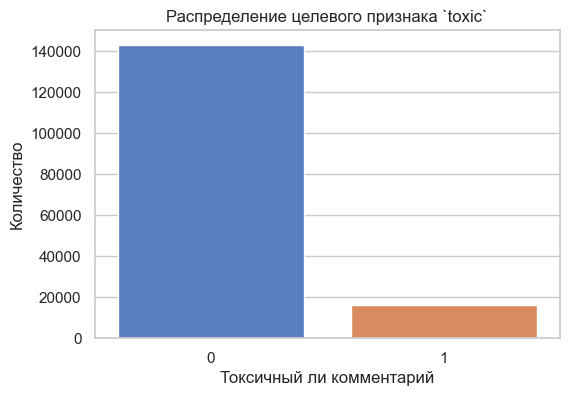

In [6]:
# Сводная таблица
toxic_pivot = (
    comments
    .pivot_table(index=['toxic'], values=['text'], aggfunc='count')
    .sort_values(by=['text'], ascending=False)
)
toxic_pivot.columns = ['Количество']
display(toxic_pivot)

# Столбчатая диаграмма
plt.figure(figsize=(6,4))
sns.barplot(data=toxic_pivot, x=toxic_pivot.index, y='Количество', palette='muted')
plt.ylabel('Количество')
plt.xlabel('Токсичный ли комментарий')
plt.title('Распределение целевого признака `toxic`')
plt.show()

Наблюдается явный **дисбаланс классов**: токсичных комментариев в 9 раз меньше, чем нетоксичных. Учтем этот момент в дальнейшей работе с данными.

Также проанализируем длину комментариев в разрезе целевого признака:

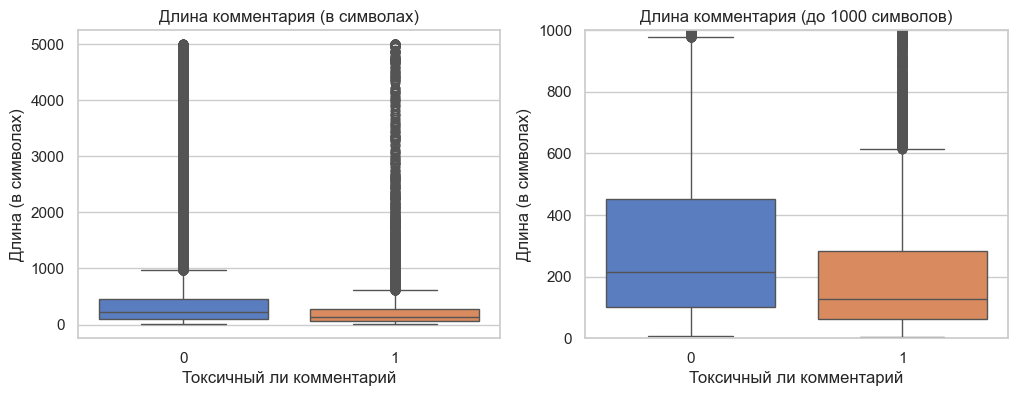

In [7]:
# Подсчет длины текста в символах
comments_analys = comments.copy()
comments_analys['text_length'] = comments_analys['text'].apply(len)

# Диаграммы размаха
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(data=comments_analys, x='toxic', y='text_length', ax=ax1, palette='muted')
ax1.set_title('Длина комментария (в символах)')
ax1.set_xlabel('Токсичный ли комментарий')
ax1.set_ylabel('Длина (в символах)')

sns.boxplot(data=comments_analys, x='toxic', y='text_length', ax=ax2, palette='muted')
ax2.set_title('Длина комментария (до 1000 символов)')
ax2.set_xlabel('Токсичный ли комментарий')
ax2.set_ylabel('Длина (в символах)')
ax2.set_ylim(0, 1000)

plt.show()

- На первом графике видно, что как для токсичных, так и для нетоксичных комментариев есть значительное количество длинных выбросов (более 1000 символов).
- На втором графике уже более явно видны различия в основных частях распределений. Медиана длины токсичных комментариев ниже, чем позитивных. Таким образом, негативные комментарии часто короче и содержат менее развернутый текст.

**Общая предварительная оценка данных:**
- Датафрейм содержит 159 292 строк с комменатриями, а также метками их токсичности (0 и 1).
- В данных отсутствуют пропущенные значения и дубликаты.
- В целевом признаке `toxic` наблюдается дисбаланс классов: токсичных комментариев ~10% от всего объема данных.
- В среднем токсичные комментарии имеет меньшую длинну (по символам) нежели позитивные комментарии.

## Предобработка данных <a class="anchor" id="предобработка"></a>

Подготовим данные к дальнейшему анализу и обучению моделей. Для векторизации текстов мы будем использовать метод **TF-IDF**. Предобработка текста будет включать в себя:
- приведение текста к нижнему регистру
- очистка текста от лишних символов, включая пунктуацию
- лемматизация текста
- удаление стоп-слов

In [8]:
# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

In [9]:
def get_wordnet_pos(treebank_tag):
    '''
    Преобразует теги частей речи из формата NLTK в формат для WordNetLemmatizer.

    Args:
        treebank_tag(str): Тег части речи, полученный из NLTK.

    Returns:
        str: Тег части речи в формате WordNet.
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [10]:
def preprocess_for_tfidf(text):
    '''
    Выполняет предобработку текста для метода TF-IDF.

    Args:
        text(str): Текст для предобработки.

    Returns:
        prep_text(str): Обработанный текст
    '''
   
    # Приведение к нижнему регистру
    prep_text = text.lower()
    
    # Удаление лишних символов
    prep_text = re.sub(r'[^a-zA-Z]', ' ', prep_text)
    prep_text = ' '.join(prep_text.split())

    # Загрузка стоп-слов
    stop_words = set(stopwords.words('english'))
    
    # Токенизация и получение частей речи
    tokens = word_tokenize(prep_text)
    postag_tokens = pos_tag(tokens)
    
    # Лемматизация токена
    lemm_tokens = [
        lemmatizer.lemmatize(token, get_wordnet_pos(postag)) 
        for token, postag in postag_tokens
    ]

    # Удаление стоп-слов
    filtered_tokens = [
        token for token in lemm_tokens 
        if token not in stop_words
    ]

    # Объединение слов в строку
    prep_text = ' '.join(filtered_tokens)

    return prep_text

In [11]:
# Инициализация tqdm для использования progress_apply
tqdm.pandas()

In [12]:
# Предобработка текста для TF-IDF
comments_tfidf = comments.copy()
comments_tfidf['lemm_text'] = comments_tfidf['text'].progress_apply(preprocess_for_tfidf)

# Проверка результатов
comments_tfidf.head()

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [15:18<00:00, 173.43it/s]


,text,toxic,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation edits make username hardcore metallica fan revert vandalism closure gas vote new york doll fac please remove template talk page since retire
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,aww match background colour seemingly stick thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man really try edit war guy constantly remove relevant information talk edits instead talk page seem care formatting actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,make real suggestion improvement wonder section statistic later subsection type accident think reference may need tidy exact format ie date format etc later one else first preference format style reference want please let know appear backlog article review guess may delay reviewer turn list relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,sir hero chance remember page


**Выводы**:

В результате предобработки данных:
- Привели текст к нижнему регистру
- Очистили текст от лишних символов, которые вносят шум в данные
- Провели лемматизацию текста
- Удалили стоп-слова

## Подготовка к обучению. Векторизация методом TF-IDF <a class="anchor" id="векторизация"></a>

Разделим данные на тренировочную (75%) и тестовую (25%) выборки, используя стратификацию по целевому признаку.

In [13]:
# Объявление констант
RANDOM_STATE = 42

# Разделение на целевой и входные признаки
X = comments_tfidf['lemm_text']
y = comments_tfidf['toxic']

# Разделение данных на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE
)

# Размерность выборок
print('Размер тренировочной выборки:', X_train.shape, y_train.shape)
print('Размер тестовой выборки:', X_test.shape, y_test.shape)

Размер тренировочной выборки: (119469,) (119469,)
Размер тестовой выборки: (39823,) (39823,)


Для подготовки данных к обучению создадим **pipeline**. Преобразуем тексты в числовые признаки, используя `TfidfVectorizer()`. Создадим униграммы и биграммы, что позволит учитывать не только важность отдельных слов, но и некоторый контекст.

In [14]:
def make_pipeline(model, ngram_range=(1, 2)):
    '''
    Args:
        model (sklearn model): Модель для классификации.
        ngram_range (tuple, optional): Диапазон n-грамм для TfidfVectorizer. По умолчанию (1, 2).
    
    Returns:
        Pipeline: Настроенный пайплайн с TfidfVectorizer и моделью.
    '''
  
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=ngram_range)),
        ('model', model)
    ])
    
    return pipeline

Для подбора наилучших гиперпараметров для каждой модели будем использовать **OptunaSearchCV**. Для оценки качества моделей будет применяться метрика **F1**.


In [15]:
def best_model_optuna(pipeline, param_distr, X_train, y_train,
                      n_trials=20, verbose=0):
    '''
    Проводит подбор гиперпараметров модели с помощью OptunaSearchCV и вычисляет ключевые метрики.

    Args:
        pipeline (Pipeline): Итоговый пайлайн для подготовки данных.
        param_distr (dict): Диапазон для поиска гиперпараметров Optuna.
        X_train(pd.DataFrame): Входные признаки тренировочной выборки.
        y_train(pd.Series): Целевой признак тренировочной выборки.
        n_trials (int, optional): Количество итераций для OptunaSearchCV. По умолчанию 20.
        verbose (int, optional): Уровень детализации вывода. По умолчанию 0.
        
    Вывод:
        - Лучшие параметры модели.
        - F1 на кросс-валидации.
    '''

    # Настройка OptunaSearchCV
    optuna_search = OptunaSearchCV(
        estimator=pipeline,
        param_distributions=param_distr,
        cv=5,
        scoring='f1',
        n_trials=n_trials,
        random_state=RANDOM_STATE,
        verbose=verbose
    )
    
    # Подбор параметров
    optuna_search.fit(X_train, y_train)

    # Модель с лучшими параметрами
    best_model = optuna_search.best_estimator_

    # Расчет F1
    f1_cv = optuna_search.best_score_

    # Вывод результтатов
    print(f'Лучшие параметры: {optuna_search.best_params_}')
    print(f'Метрика F1 на кросс-валидации: {f1_cv}')
 
    return best_model, f1_cv

**Выводы:**

- Разделили данные на тренировочную и тестовую выборки.
- Создали пайплайн для подготовки данных к обучению с векторизацией текста в числовые значения.
- Написали функцию для поиска гиперпараметров модели с помощью OptunaSearchCV, а также расчета ключевых метрик.

## Обучение моделей <a class="anchor" id="обучение"></a>

Для поиска лучшей модели протестируем 4 варианта:
- **LogisticRegression**
- **MultinomialNB**
- **SGDClassifier**
- **LGBMClassifier**

Для учета дисбаланса классов в параметрах моделей будем указывать `class_weight='balanced'`.

### LogisticRegression <a class="anchor" id="LogisticRegression"></a>

In [16]:
# Создание пайплайна для LogisticRegression
pipe_log_reg = make_pipeline(LogisticRegression(class_weight='balanced', 
                                                random_state=RANDOM_STATE))

# Гиперпараметры LogisticRegression
params_log_reg = {
    'model__C': optuna.distributions.FloatDistribution(0.01, 10, log=True)
}

# Подбор гиперпараметров и обучение модели
log_reg_model, log_reg_f1 = best_model_optuna(
    pipe_log_reg, 
    params_log_reg, 
    X_train, 
    y_train, 
    n_trials=20)

[I 2024-11-06 17:21:18,232] A new study created in memory with name: no-name-56b17106-aa48-4057-a2be-b94dd209981c
[I 2024-11-06 17:23:18,928] Trial 0 finished with value: 0.7027110022667016 and parameters: {'model__C': 0.2312614033209604}. Best is trial 0 with value: 0.7027110022667016.
[I 2024-11-06 17:25:29,538] Trial 1 finished with value: 0.7642760772577415 and parameters: {'model__C': 3.1469953191648936}. Best is trial 1 with value: 0.7642760772577415.
[I 2024-11-06 17:27:14,664] Trial 2 finished with value: 0.6786880932330843 and parameters: {'model__C': 0.01611216952262752}. Best is trial 1 with value: 0.7642760772577415.
[I 2024-11-06 17:29:06,649] Trial 3 finished with value: 0.6840627368661482 and parameters: {'model__C': 0.09085351895012907}. Best is trial 1 with value: 0.7642760772577415.
[I 2024-11-06 17:31:08,493] Trial 4 finished with value: 0.7085452495428771 and parameters: {'model__C': 0.28547072560927855}. Best is trial 1 with value: 0.7642760772577415.
[I 2024-11-06

Лучшие параметры: {'model__C': 8.879352172698267}
Метрика F1 на кросс-валидации: 0.7755397613016577


### MultinomialNB <a class="anchor" id="MultinomialNB"></a>

In [17]:
# Создание пайплайна для MultinomialNB
pipe_multi_nb = make_pipeline(MultinomialNB(class_prior=[0.9, 0.1]))

# Гиперпараметры MultinomialNB
params_multi_nb = {
    'model__alpha': optuna.distributions.FloatDistribution(0.01, 10, log=True)
}

# Подбор гиперпараметров и обучение модели
multi_nb_model, multi_nb_f1 = best_model_optuna(
    pipe_multi_nb, 
    params_multi_nb, 
    X_train, 
    y_train, 
    n_trials=20)

[I 2024-11-06 18:04:27,633] A new study created in memory with name: no-name-a5d93a7b-37e7-4d8e-b293-52505c38d273
[I 2024-11-06 18:05:54,751] Trial 0 finished with value: 0.34381105923987204 and parameters: {'model__alpha': 0.2312614033209604}. Best is trial 0 with value: 0.34381105923987204.
[I 2024-11-06 18:07:22,753] Trial 1 finished with value: 0.07758014032430852 and parameters: {'model__alpha': 3.1469953191648936}. Best is trial 0 with value: 0.34381105923987204.
[I 2024-11-06 18:08:51,177] Trial 2 finished with value: 0.6444526653556254 and parameters: {'model__alpha': 0.01611216952262752}. Best is trial 2 with value: 0.6444526653556254.
[I 2024-11-06 18:10:19,666] Trial 3 finished with value: 0.49593489099088855 and parameters: {'model__alpha': 0.09085351895012907}. Best is trial 2 with value: 0.6444526653556254.
[I 2024-11-06 18:11:49,226] Trial 4 finished with value: 0.3103890601120241 and parameters: {'model__alpha': 0.28547072560927855}. Best is trial 2 with value: 0.644452

Лучшие параметры: {'model__alpha': 0.01029464512193182}
Метрика F1 на кросс-валидации: 0.6542001163602452


### SGDClassifier <a class="anchor" id="SGDClassifier"></a>

In [18]:
# Создание пайплайна для SGDClassifier
pipe_sgdc = make_pipeline(SGDClassifier(class_weight='balanced',
                                        random_state=RANDOM_STATE))

# Гиперпараметры SGDClassifier
params_sgdc = {
    'model__loss': optuna.distributions.CategoricalDistribution(['hinge', 'squared_hinge', 'perceptron']),
    'model__alpha': optuna.distributions.FloatDistribution(1e-5, 1e-3)
}

# Подбор гиперпараметров и обучение модели
sgdc_model, sgdc_f1 = best_model_optuna(
    pipe_sgdc, 
    params_sgdc, 
    X_train, 
    y_train,
    n_trials=20)

[I 2024-11-06 18:33:44,749] A new study created in memory with name: no-name-7a2b6bfe-effc-4509-af9c-80799e325a4a
[I 2024-11-06 18:35:08,964] Trial 0 finished with value: 0.7165898236155471 and parameters: {'model__loss': 'squared_hinge', 'model__alpha': 0.0003262527785293697}. Best is trial 0 with value: 0.7165898236155471.
[I 2024-11-06 18:36:32,801] Trial 1 finished with value: 0.7124024492012244 and parameters: {'model__loss': 'hinge', 'model__alpha': 0.00017507936959010998}. Best is trial 0 with value: 0.7165898236155471.
[I 2024-11-06 18:37:54,950] Trial 2 finished with value: 0.6821844542432287 and parameters: {'model__loss': 'perceptron', 'model__alpha': 0.0009992583517366939}. Best is trial 0 with value: 0.7165898236155471.
[I 2024-11-06 18:39:18,576] Trial 3 finished with value: 0.7089787770698368 and parameters: {'model__loss': 'hinge', 'model__alpha': 0.0004780097647750324}. Best is trial 0 with value: 0.7165898236155471.
[I 2024-11-06 18:40:43,853] Trial 4 finished with va

Лучшие параметры: {'model__loss': 'hinge', 'model__alpha': 1.1113433348773734e-05}
Метрика F1 на кросс-валидации: 0.7820848686315427


### LGBMClassifier <a class="anchor" id="LGBMClassifier"></a>

In [19]:
# Создание пайплайна для SGDClassifier
pipe_lgbmc = make_pipeline(LGBMClassifier(class_weight='balanced',
                                          random_state=RANDOM_STATE, 
                                          force_row_wise=True, 
                                          verbose=-1))

# Гиперпараметры
params_lgbmc = {
    'model__n_estimators': optuna.distributions.IntDistribution(50, 300),
    'model__learning_rate': optuna.distributions.FloatDistribution(0.01, 1, 0.02)
}

# Подбор гиперпараметров и обучение моделиz
lgbmc_tmodel, lgbmc_f1 = best_model_optuna(
    pipe_lgbmc, 
    params_lgbmc, 
    X_train, 
    y_train,
    n_trials=10)

[I 2024-11-06 19:02:15,833] A new study created in memory with name: no-name-8957e55f-29e6-4671-8f9c-87a657fd7e37
[I 2024-11-06 19:07:00,012] Trial 0 finished with value: 0.7597062053209818 and parameters: {'model__n_estimators': 164, 'model__learning_rate': 0.4626622490126815}. Best is trial 0 with value: 0.7597062053209818.
[I 2024-11-06 19:10:53,239] Trial 1 finished with value: 0.6903604588457215 and parameters: {'model__n_estimators': 67, 'model__learning_rate': 0.04354060928873476}. Best is trial 0 with value: 0.7597062053209818.
[I 2024-11-06 19:16:20,997] Trial 2 finished with value: 0.7194119633196829 and parameters: {'model__n_estimators': 171, 'model__learning_rate': 0.03949328531300317}. Best is trial 0 with value: 0.7597062053209818.
[I 2024-11-06 19:20:55,377] Trial 3 finished with value: 0.6804996506761186 and parameters: {'model__n_estimators': 103, 'model__learning_rate': 0.021552302595488446}. Best is trial 0 with value: 0.7597062053209818.
[I 2024-11-06 19:25:12,334]

Лучшие параметры: {'model__n_estimators': 164, 'model__learning_rate': 0.4626622490126815}
Метрика F1 на кросс-валидации: 0.7597062053209818


**Выводы:**

В результате было обучено 4 модели. Для каждой модели с помощью OptunaSearchCV были подобраны гиперпараметры, с которыми модель показывает наилучшую метрику F1. Гиперпараметры моделей:
- **LogisticRegression** - 'C': 8.879352172698267.
- **MultinomialNB** - 'alpha': 0.01029464512193182.
- **SGDClassifier** - 'loss': 'hinge', 'alpha': 1.1113433348773734e-05.
- **LGBMClassifier** - 'n_estimators': 164, 'learning_rate': 0.4626622490126815.

## Анализ результатов. Тестирование лучшей модели <a class="anchor" id="результаты"></a>

Добавим результаты всех моделей в датафрейм и сравним их:

In [20]:
# Создание датафрейма с результатами моделей
models_results = pd.DataFrame({
    'model': ['LogisticRegression', 
              'MultinomialNB', 
              'SGDClassifier', 
              'LGBMClassifier'],
    'F1_cv' : [log_reg_f1, 
               multi_nb_f1, 
               sgdc_f1, 
               lgbmc_f1]
}).sort_values(by='F1_cv', ascending=False)

display(models_results)

,model,F1_cv
2,SGDClassifier,0.782085
0,LogisticRegression,0.775540
3,LGBMClassifier,0.759706
1,MultinomialNB,0.654200


- **SGDClassifier** показала наилучшее качество предсказаний с наибольшим значением F1 - 0.782085.
- Самую низкую точность прогноза показала модель MultinomialNB - F1 составила 0.654200.

Проверим качество лучшей модели (SGDClassifier) на тестовой выборке. А также построим матрицу ошибок.

In [21]:
# Прогноз на тестовой выборке
y_pred = sgdc_model.predict(X_test)

# F1 на тестовой выборке
f1_score_test = f1_score(y_test, y_pred)
print(f'F1 на тестовой выборке: {f1_score_test:.4f}')

F1 на тестовой выборке: 0.7812


Видим, что метрика F1 практически не отличается между тренировочной и тестовой выборками, что говорит о **хорошей обобщающей способности модели** и отсутствии переобучения.

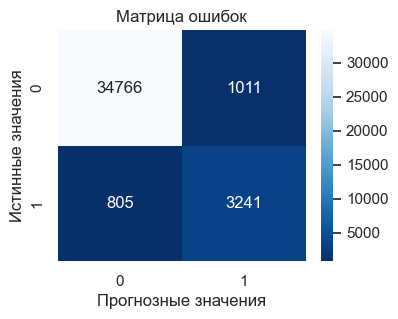

In [22]:
# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('Истинные значения')
plt.xlabel('Прогнозные значения');

Видим, что модель пропустила всего 805 токсичных комментариев (False Negatives), тогда как правильно классифицировано 3,241 таких комментариев. Это довольно хороший показатель, особенно в условиях, когда класс токсичных комментариев встречается редко (берем во внимание дисбаланс классов). Модель смогла поймать большинство из них.

Таким образом, **SGDClassifier** показал наилучшие результаты по сравнению с другими моделями, что делает его предпочтительным выбором для данной задачи классификации.

## Общий вывод <a class="anchor" id="вывод"></a>

В ходе проведенного исследования были выполнены следующие этапы и получены следующие основные результаты.

1) **Обзор данных**
- Выявили дисбаланс классов в целевом признаке (токсичных комментариев ~10% от всего объема данных).
- Были проверены пропущенные значения, а также дубликаты. Их не обнаружили
***
2) **Предобработка данных**

- Привели текст к нижнему регистру
- Очистили текст от лишних символов
- Провели лемматизацию текста
- Удалили стоп-слова

Это позволило уменьшить влияние шума в данных, снизить размерность данных и улучшить качество моделей.
***
3) **Подготовка к обучению. Векторизация текста**

Для векторизации текстов был использован метод TF-IDF с созданием уни- и биграмм. Данный метод позволяет оценить значимость слова в тексте относительно всех текстов, что помогает выделить ключевые термины и уменьшить влияние часто встречающихся слов. 

Использование униграмм и биграмм расширило представление текстов, что позволило учитывать как отдельные слова, так и их сочетания, что помогло уловить контекст и семантические связи между словами. 
***
4) **Обучение моделей. Анализ результатов**

Было обучено 4 модели: **LogisticRegression, MultinomialNB,  SGDClassifier, LGBMRegressor**. Для каждой модели при помощи OptunaSearchCV были подобраны гиперпараметры и рассчитана метрика F1.

Наилучшее качество предсказаний с наибольшим значением F1 (0.782085) показала **SGDClassifier**. На тестовой выборке показатель F1 составил **0.7812**, т.е. удовлетворяющий критерию.
***
5) **Итоги исследования**
- В ходе исследования была построена модель для классификации комментариев на токсичные и нетоксичные.
- Наилучшие результаты по качеству предсказания продемонстрировала модель **SGDClassifier** с показателем F1 0.7812 на тестовой выборке. Эта модель соответствует критериям проекта и показывает удовлетворительный уровень точности.